# Compute grads and save to file

In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
import os
import sys
sys.path.insert(0, '/home/jovyan/braindecode/')
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from decode_tueg import (
    load_exp, DataScaler, TargetScaler, Augmenter, 
    save_csv, iter_exp_dir, get_freqs_and_info, compute_gradients,
    get_datasets,
)

Fri Sep 15 09:08:14 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.60.13    Driver Version: 525.60.13    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:3D:00.0 Off |                  N/A |
| 27%   27C    P8     1W / 250W |      1MiB / 11264MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
batch_size = 128
n_jobs = 4
n_recordings = 10
exp_dir = '/home/jovyan/experiments/'
exp_date = '2023-02-15T18:43:26.819382'
checkpoint = 'train_end'
age_ranges = [(0,30), (30,60), (60, 100)]
input_times_gradient = False
save_grads = True

Fri Sep 15 09:24:46 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.60.13    Driver Version: 525.60.13    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:3D:00.0 Off |                  N/A |
| 27%   37C    P8     2W / 250W |   7567MiB / 11264MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [44]:
for ds_name in ['eval', 'eval_not_normal']:
    for exp_path in iter_exp_dir(exp_dir, exp_date):
        print(f'loading exp {exp_path}')
        clf, data_scaler, target_scaler, config = load_exp(
            exp_dir, exp_path, checkpoint)
        print(f'getting {ds_name}')
        # load preprocessed and windowed dataset
        if ds_name in ['eval', 'eval_not_normal']:
            p = f'/home/jovyan/{ds_name}_pre_win.pkl'
        else:
            p = f'/home/jovyan/longitudinal/{ds_name}_pre_win.pkl'
        with open(p, 'rb') as f:
            ds = pickle.load(f)
        if n_recordings not in [-1, None]:
            ds = ds.split(list(range(n_recordings)))['0']
        # if data transform is not set, get it from eval
        if ds.transform[0] is None:
            p = f'/home/jovyan/eval_pre_win.pkl'
            with open(p, 'rb') as f:
                ds_eval = pickle.load(f)
            ds.transform = ds_eval.transform[0]
        assert ds.transform[-1] is not None
        #ds.transform = lambda x: x*0  # !!!!!!!!!!!!!!!!!!!!!!!!!!!
        print('computing gradients')
        grads = compute_gradients(clf, ds, batch_size, n_jobs, input_times_gradient, age_ranges)
        # create grads output subdir
        if save_grads:
            #out_path = os.path.join(exp_dir, exp_path, 'grads')
            out_path = os.path.join('/home/jovyan/tmp2/', exp_path, 'grads')  # !!!!!!!!!!!!!!!!!!!!!!!!!
            print(f'saving {out_path}')
            if not os.path.exists(out_path):
                os.makedirs(out_path)
            save_csv(grads, out_path, f'{checkpoint}_{ds_name}_grads.csv')
        #break
    #break

loading exp 2023-02-15T18:43:26.819382/20230214/0
getting eval
computing gradients
n datasets 10
grads (1, 2718, 21, 3001)
description (2718, 19)
no subjects in specified age range
saving /home/jovyan/tmp2/2023-02-15T18:43:26.819382/20230214/0/grads
loading exp 2023-02-15T18:43:26.819382/20230215/0
getting eval
computing gradients
n datasets 10
grads (1, 2718, 21, 3001)
description (2718, 19)
no subjects in specified age range
saving /home/jovyan/tmp2/2023-02-15T18:43:26.819382/20230215/0/grads
loading exp 2023-02-15T18:43:26.819382/20230216/0
getting eval
computing gradients
n datasets 10
grads (1, 2718, 21, 3001)
description (2718, 19)
no subjects in specified age range
saving /home/jovyan/tmp2/2023-02-15T18:43:26.819382/20230216/0/grads
loading exp 2023-02-15T18:43:26.819382/20230217/0
getting eval
computing gradients
n datasets 10
grads (1, 2718, 21, 3001)
description (2718, 19)
no subjects in specified age range
saving /home/jovyan/tmp2/2023-02-15T18:43:26.819382/20230217/0/grads


In [46]:
print("HI")

HI


# Read grads from files and plot

In [47]:
import os
import sys
sys.path.insert(0, '/home/jovyan/braindecode/')
import numpy as np
import pandas as pd
from decode_tueg import (
    plot_band_grads, freqs_to_bin, iter_exp_dir, make_info)

In [48]:
exp_dir = '/home/jovyan/experiments/'
exp_dir = '/home/jovyan/tmp2/'
exp_date = '2023-02-15T18:43:26.819382'
#exp_date = '2023-02-22T12:51:02.928667'  # !
checkpoint = 'train_end'

In [49]:
bands = [(0,4),(4,8),(8,12),(12,30),(30,50)]

In [50]:
ds_names = ['eval', 'eval_not_normal']

In [138]:
all_grads = []
for ds_name in ds_names:
    for exp_path in iter_exp_dir(exp_dir, exp_date):
        print(exp_path)
        grads = pd.read_csv(os.path.join(exp_dir, exp_path, 'grads', f'{checkpoint}_{ds_name}_grads.csv'), index_col=0)
        all_grads.append(grads)
all_grads = pd.concat(all_grads).reset_index().groupby(['index', 'pathological', 'age_range'], as_index=False).mean().set_index('index')

2023-02-15T18:43:26.819382/20230214/0
2023-02-15T18:43:26.819382/20230215/0
2023-02-15T18:43:26.819382/20230216/0
2023-02-15T18:43:26.819382/20230217/0
2023-02-15T18:43:26.819382/20230218/0
2023-02-15T18:43:26.819382/20230214/0
2023-02-15T18:43:26.819382/20230215/0
2023-02-15T18:43:26.819382/20230216/0
2023-02-15T18:43:26.819382/20230217/0
2023-02-15T18:43:26.819382/20230218/0


In [139]:
all_grads

,pathological,age_range,0.0,0.016666666666666666,0.03333333333333333,0.05,0.06666666666666667,0.08333333333333333,0.1,0.11666666666666667,...,49.85,49.86666666666667,49.88333333333333,49.9,49.916666666666664,49.93333333333333,49.95,49.96666666666667,49.983333333333334,50.0
index,,,,,,,,,,,,,,,,,,,,,
A1,False,"(0, 30)",2.937123e-10,-3.445277e-09,-8.767883e-10,-7.370504e-09,-6.098674e-09,-4.560814e-09,-7.206732e-09,-3.359534e-09,...,-8.966675e-12,-3.308152e-10,3.213202e-10,1.144109e-09,6.077842e-10,-8.724225e-10,8.566607e-10,-6.365721e-10,-9.066394e-10,-2.468685e-10
A1,False,"(30, 60)",-4.321623e-11,5.559758e-09,8.422785e-10,-3.992048e-09,-5.299338e-10,-4.918662e-10,1.594914e-09,1.733814e-09,...,-4.603348e-10,-1.385007e-10,1.021936e-09,1.511119e-09,2.201708e-09,1.090506e-09,1.088273e-09,3.754733e-10,5.170525e-10,-5.844410e-11
A1,True,"(30, 60)",-1.105254e-08,-9.948760e-10,-1.283347e-09,1.106308e-09,1.200064e-09,1.742942e-09,2.051836e-09,-2.652469e-09,...,3.068527e-10,3.813755e-10,1.458351e-10,1.205871e-10,4.904281e-10,2.103510e-10,6.403249e-10,-3.212359e-10,8.447078e-12,4.732892e-10
A1,True,"(60, 100)",4.562678e-09,-5.701063e-09,-5.279911e-09,1.330674e-09,-2.708579e-11,5.091965e-10,-7.187276e-10,-7.665021e-10,...,3.317139e-10,-2.984646e-10,6.109508e-10,-2.808227e-10,2.431972e-10,5.265567e-10,2.387463e-10,4.280243e-10,1.772218e-11,-4.597162e-10
A2,False,"(0, 30)",-1.688513e-09,-1.606393e-09,-3.617672e-09,1.341675e-09,1.694696e-09,-1.759604e-09,8.528814e-10,-2.068183e-10,...,-2.356470e-09,-9.920041e-10,-1.755695e-09,-3.439812e-10,-1.088325e-09,-1.157767e-09,-1.153801e-09,-6.663081e-10,-5.632691e-10,-4.290543e-10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
T5,True,"(60, 100)",-7.014647e-11,-7.027828e-10,-1.173321e-09,-1.563652e-10,-3.815881e-10,1.506700e-09,1.579205e-09,1.751822e-09,...,1.255177e-09,1.493240e-09,1.252130e-09,1.933169e-09,9.549212e-10,1.981801e-09,1.016329e-09,2.043683e-09,1.184497e-09,4.077230e-10
T6,False,"(0, 30)",-3.576605e-09,-1.202165e-09,-2.044809e-09,8.043525e-09,4.782866e-09,5.055781e-09,3.507131e-09,-1.006918e-09,...,2.249628e-09,2.589196e-09,4.530001e-09,4.947198e-09,5.840893e-09,4.737074e-09,3.715644e-09,2.604452e-09,6.040940e-09,1.157829e-09
T6,False,"(30, 60)",5.500965e-09,-2.245682e-09,1.510580e-10,-1.363651e-09,-2.531924e-09,5.645866e-10,8.474527e-10,-5.776914e-10,...,4.017423e-09,3.371045e-09,5.480712e-09,4.950188e-09,3.216661e-09,2.672293e-09,3.103368e-09,4.146283e-09,2.040712e-09,1.728076e-09


In [140]:
all_grads.groupby(['pathological', 'age_range']).max().max(axis=1)

pathological  age_range
False         (0, 30)      6.091522e-08
              (30, 60)     5.889237e-08
True          (30, 60)     3.086000e-08
              (60, 100)    3.851845e-08
dtype: float64

In [141]:
all_grads.groupby(['pathological', 'age_range']).min().min(axis=1)

pathological  age_range
False         (0, 30)     -7.259479e-08
              (30, 60)    -8.109896e-08
True          (30, 60)    -3.332136e-08
              (60, 100)   -3.457811e-08
dtype: float64

In [142]:
all_grads.groupby(['pathological', 'age_range']).mean().mean(axis=1)

pathological  age_range
False         (0, 30)      1.341550e-10
              (30, 60)    -4.349702e-10
True          (30, 60)    -1.600454e-10
              (60, 100)    2.123368e-10
dtype: float64

In [143]:
grads = all_grads

In [144]:
all_band_grads[band][age_range]

{True: array([ 3.15031266e-09, -1.17560314e-10,  1.68111349e-09,  1.20508070e-09,
        -4.05888971e-10, -2.88109490e-09, -2.61037982e-09, -9.95932246e-10,
        -3.10850313e-10,  1.56782066e-09,  9.35863162e-10, -3.13489351e-09,
        -2.59781653e-09, -2.57485165e-09,  3.80475025e-10,  9.99011685e-10,
         4.19772220e-10,  1.50550264e-09, -3.62113589e-10, -2.90654113e-09,
        -3.96813590e-09])}

0.0 4.0
4.0 8.0
8.0 12.0
12.0 30.0
30.0 50.0


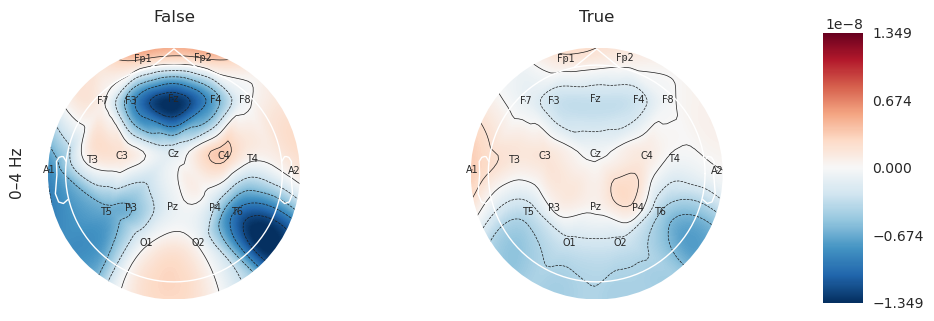

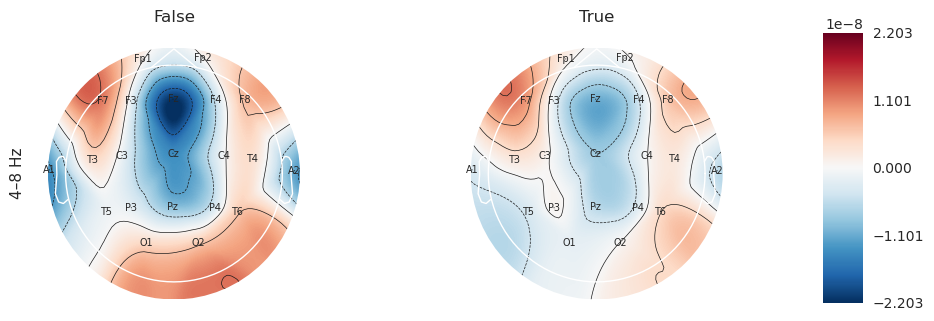

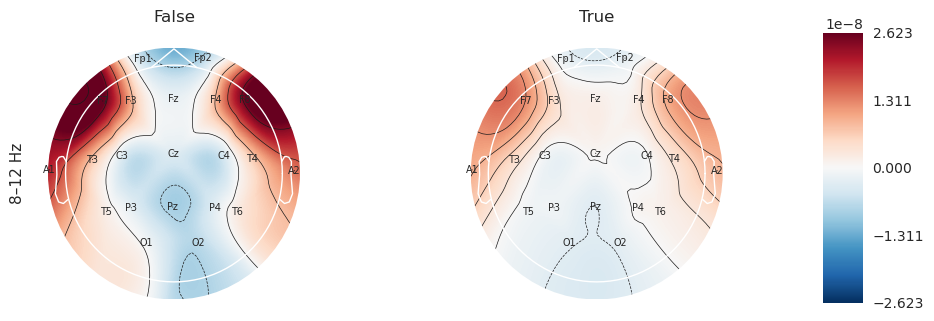

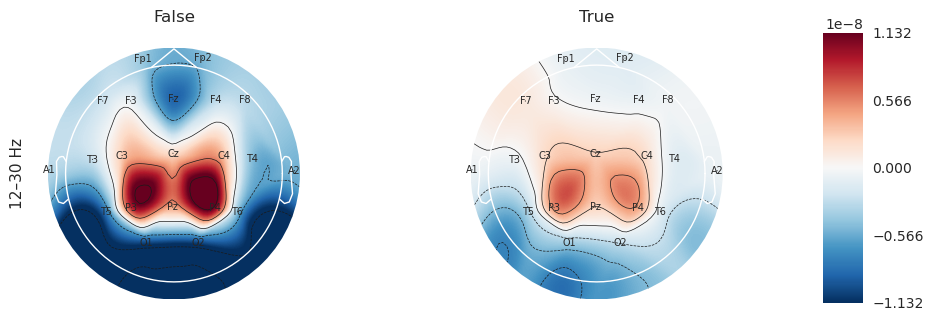

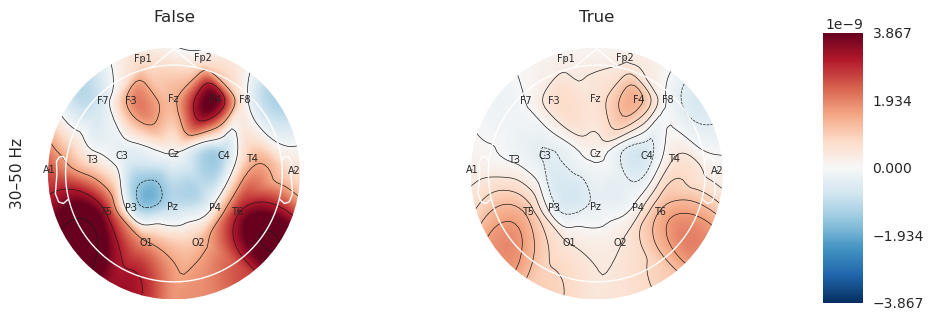

In [145]:
# without age range
all_band_grads = {}
all_band_grads_dfs = []
for band_i, band in enumerate(bands):
    all_band_grads[band] = {}
    for (pathological, age_range), g in grads.groupby(['pathological', 'age_range']):
        g.drop(['pathological', 'age_range'], inplace=True, axis=1)
        names = list(g.index)
        freqs = np.array([float(f) for f in g.columns])
        g = g.values

        l, h = freqs_to_bin(freqs, band)
        band_freqs = freqs[l:h+1]
        band_grads = g[:,l:h+1].mean(axis=1)
        all_band_grads[band][pathological] = band_grads
        
        tmp = pd.DataFrame([band_grads], columns=list(range(len(names))), index=[band_i])
        tmp['pathological'] = pathological
        tmp['age_range'] = age_range
        all_band_grads_dfs.append(tmp)
    print(band_freqs[0], band_freqs[-1])
    fig = plot_band_grads(all_band_grads[band], make_info(names, 100), band, False, gradients_x_input=False)

In [146]:
from decode_tueg import save_fig

In [147]:
save_figures = False

In [148]:
to_plot = {False: {}, True: {}}
for band, subset_band_grads in all_band_grads.items():
    for pathological, band_grads in subset_band_grads.items():
        print(band, pathological)
        to_plot[pathological][band] = band_grads

(0, 4) False
(0, 4) True
(4, 8) False
(4, 8) True
(8, 12) False
(8, 12) True
(12, 30) False
(12, 30) True
(30, 50) False
(30, 50) True


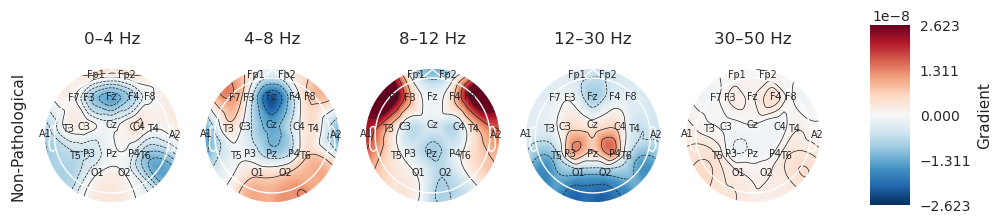

In [149]:
fig = plot_band_grads(to_plot[False], info=make_info(names, 100), band=[False], flip_x_y=True, gradients_x_input=False)
fig.get_axes()[0].set_ylabel('Non-Pathological')
fig.get_axes()[0].yaxis.set_label_coords(-.15, .5)
fig.get_axes()[-1].set_ylabel('Gradient')
if save_figures:
    save_fig(fig, '/home/jovyan/figures/', 'non_patho_amplitude_perturbation')

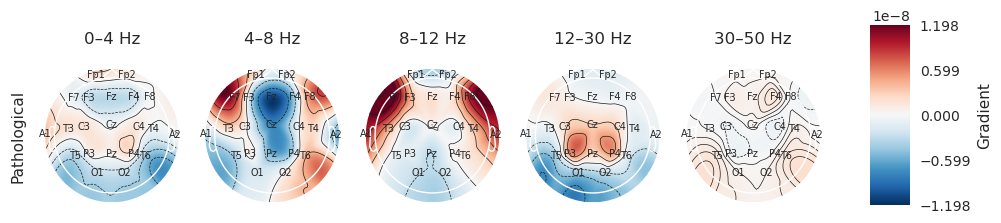

In [150]:
fig = plot_band_grads(to_plot[True], info=make_info(names, 100), band=[True], flip_x_y=True, gradients_x_input=False)
fig.get_axes()[0].set_ylabel('Pathological')
fig.get_axes()[0].yaxis.set_label_coords(-.15, .5)
fig.get_axes()[-1].set_ylabel('Gradient')
if save_figures:
    save_fig(fig, '/home/jovyan/figures/', 'patho_amplitude_perturbation')

In [151]:
# compute difference between non-patho und patho
to_plot = {}
for band, grads in all_band_grads.items():
    to_plot[band] = grads[False] - grads[True]

In [152]:
save_figures = False

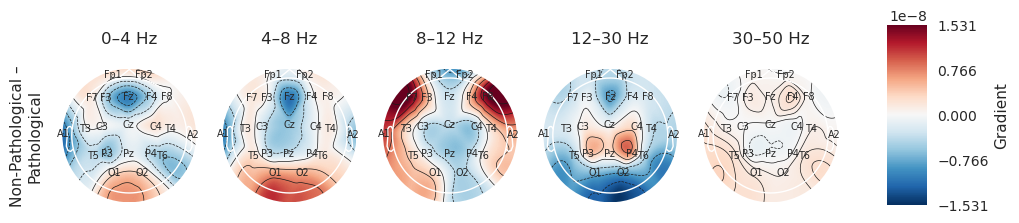

In [153]:
fig = plot_band_grads(to_plot, info=make_info(names, 100), band=[True], flip_x_y=True, gradients_x_input=False)
fig.get_axes()[0].set_ylabel('Non-Pathological –\nPathological')
fig.get_axes()[0].yaxis.set_label_coords(-.15, .5)
fig.get_axes()[-1].set_ylabel('Gradient')
if save_figures:
    save_fig(fig, '/home/jovyan/figures/', 'non_patho-patho_amplitude_perturbation')